<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [146]:
%%capture
pip install pyswarms

In [147]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [148]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'

In [149]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [150]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [151]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [152]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [153]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [154]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [155]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [156]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [157]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [158]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


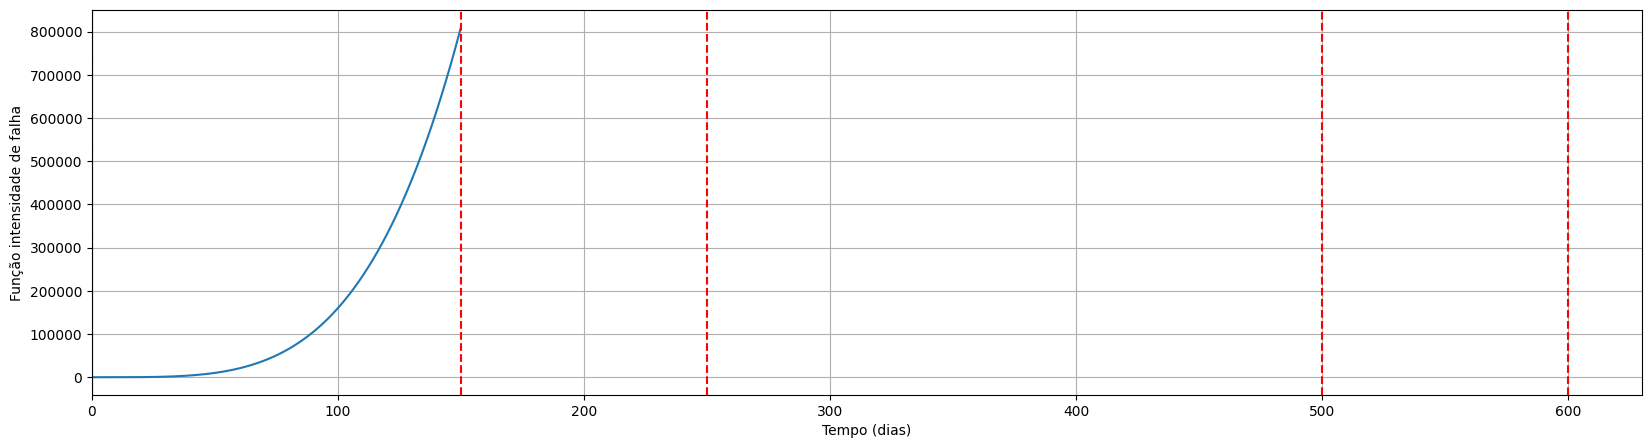

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [159]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [169]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(X):
    X = np.squeeze(X).astype(int)  # Converte X em uma matriz unidimensional de inteiros

    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0} # Dicionario para severidades

    global s
    T = [0]
    s_row = []
    cont = 0

    converter = np.vectorize(lambda x: int(x) % 2)
    X_int = converter(X)

    it = np.nditer(X_int, flags=['multi_index'])
    while not it.finished:
        number = it[0]
        index = it.multi_index
        if np.any(number == 1):
            number_int = int(number)
            if number_int in dict_severidades:
                s_row.append(dict_severidades[number_int])  # Severidade
                frac = number - number_int  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
        cont += 1
        it.iternext()

    s = []
    for row in range(m):
        s.append(s_row)

# A partir da solução define o número de ciclos
# A variável m é o número de sistemas em análise: em nosso exemplo m = 4
# Para novos dados esse parâmetro deve ser ajustado
# m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])


    if ck == 0:
        return CMP

# O modelo já está ajustado
# Utilizado para avaliar a solução candidata

# Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)


# Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

# Número médio de falhas até o final do período: 2 anos
    final = 730
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    custo = min(Ctotal)

    print("")
    print('Custo = ', custo)
    print("=========================================================================")
    print("")

    # Retorna o custo
    return custo

In [170]:
num_particles = 10
max_iterations = 100
dimensions = 30
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Lista para armazenar o custo em cada iteração
cost_history = []

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)
    cost_history.append(best_cost)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-07-03 21:45:08,418 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   6%|▌         |6/100, best_cost=2e+3



Número de ciclos de manutenção: 0 5
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []


Número de ciclos de manutenção: 143 5
Tempos para manutenções preventivas: [0, 60, 120, 210, 270, 300, 330, 360, 420, 450, 540, 570, 660, 750, 870, 900, 960, 1050, 1110, 1140, 1170, 1230, 1290, 1320, 1380, 1440, 1500, 1530, 1560, 1650, 1740, 1830, 1890, 1950, 1980, 2070, 2130, 2160, 2190, 2220, 2250, 2340, 2400, 2550, 2610, 2700, 2760, 2820, 2910, 3030, 3060, 3150, 3180, 3210, 3330, 3420, 3630, 3660, 3780, 3840, 3930, 3960, 3990, 4020, 4050, 4080, 4140, 4170, 4200, 4230, 4260, 4290, 4350, 4380, 4530, 4590, 4620, 4650, 4680, 4830, 4890, 5130, 5160, 5310, 5400, 5430, 5460, 5490, 5670, 5700, 5730, 5790, 5880, 5910, 5940, 5970, 6030, 6090, 6180, 6210, 6270, 6360, 6450, 6480, 6630, 6690, 6750, 6810, 6870, 6930, 7020, 7110, 7170, 7200, 7290, 7350, 7380, 7500, 7560, 7680, 7710, 7740, 7830, 7950, 8010, 8070, 8100, 8160, 8190, 8220, 8310, 8340, 8370, 8400, 8430, 8460, 8490, 8580,

pyswarms.single.global_best:  19%|█▉        |19/100, best_cost=2e+3


Custo =  16588833.333333336



Número de ciclos de manutenção: 127 5
Tempos para manutenções preventivas: [0, 60, 120, 270, 300, 330, 360, 420, 450, 570, 660, 690, 720, 810, 870, 960, 990, 1050, 1110, 1170, 1230, 1290, 1320, 1380, 1440, 1470, 1530, 1560, 1860, 1890, 1980, 2070, 2130, 2160, 2250, 2340, 2400, 2490, 2550, 2700, 2760, 2820, 3000, 3150, 3180, 3210, 3390, 3630, 3660, 3720, 3780, 3840, 3870, 3930, 3990, 4050, 4080, 4110, 4260, 4290, 4350, 4380, 4470, 4500, 4590, 4680, 4710, 4770, 4800, 4830, 4950, 4980, 5070, 5160, 5400, 5430, 5460, 5490, 5700, 5790, 5910, 5940, 5970, 6060, 6090, 6180, 6210, 6270, 6360, 6450, 6480, 6630, 6690, 6720, 6750, 6840, 6870, 6930, 7170, 7200, 7260, 7290, 7320, 7380, 7440, 7500, 7530, 7560, 7650, 7680, 7710, 7830, 7950, 8070, 8100, 8160, 8190, 8220, 8340, 8370, 8400, 8460, 8580, 8670, 8700, 8760, 8790, 8910]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.

pyswarms.single.global_best:  32%|███▏      |32/100, best_cost=2e+3

 [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666

pyswarms.single.global_best:  46%|████▌     |46/100, best_cost=2e+3



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 450, 570, 1380, 1920, 2760, 7380, 8370]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 5904900000.000001, 9370372491.276894, 667598196937.1741, 2120439574817.7163, 11791801317176.732, 3168349623972831.0, 4154935496766510.0, 3040472370051104.0]

Custo =  52488000004.44445



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 570, 1050, 1380, 1560, 1920, 2220, 2760, 4590, 5670, 6270, 6870, 7230, 7350, 7380, 7710, 8370]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.393469340287

pyswarms.single.global_best:  60%|██████    |60/100, best_cost=2e+3



Número de ciclos de manutenção: 20 5
Tempos para manutenções preventivas: [0, 270, 330, 660, 870, 960, 1110, 1170, 1920, 2160, 2250, 2610, 2760, 4680, 5070, 5160, 5640, 6270, 7500, 7680, 8370]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 459165024.00000006, 657107271.0465378, 13956160048.564514, 37762512177.11876, 53442622843.01903, 99400954458.08258, 122966954994.66656, 2185593236769.1807, 3249348100739.08, 3735993636054.8467, 710455

pyswarms.single.global_best:  74%|███████▍  |74/100, best_cost=2e+3



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 660, 1230, 1860, 1920, 2160, 3210, 7140, 7290]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 40074642432.0, 375008177456.14355, 1879736753641.9539, 2052681941091.4946, 3116436805061.394, 25313304661008.08, 2259803272453000.5, 2350271181245774.5, 1795144600760563.0]

Custo =  242876620803.0303



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 1920, 3210, 6180, 7140, 7290, 8940]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 8349416423424.001, 4358

pyswarms.single.global_best:  88%|████████▊ |88/100, best_cost=2e+3



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 270, 570, 2790, 3480, 6090, 6480, 8940]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 459165024.00000006, 8634876422.775696, 35586434058647.45, 55696373829827.92, 792519766709228.2, 935941012666286.1, 4045889485812396.5, 2491988582082645.0]

Custo =  6802444807.407409



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 270, 570, 2370, 3480, 3990, 6090, 6480, 8100, 8940]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Me

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=2e+3
2023-07-03 21:45:10,076 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33063448 0.17381099 0.9479269  0.79283351 0.6335554  0.0041557
 0.6647588  0.37023996 0.01625949 0.97121799 0.52839296 0.6088093
 0.56724194 0.02794247 0.65936101 0.70208916 0.8164775  0.70322066
 0.69004858 0.99338321 0.23077892 0.49428425 0.78950291 0.43391258
 0.27288796 0.44247182 0.01744286 0.06040957 0.1611426  0.9548383 ]
2023-07-03 21:45:10,081 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 570, 3480, 3570, 3840, 5160, 6090, 7350, 8130, 8850]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 123754759003176.02, 126867303947489.47, 139046397722599.7, 324160203083363.75, 580946964376709.8, 1315526345840329.0, 2013845156177823.0, 2925097724040959.0, 1448532503882287.2]

Custo =  135116812803.50877



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 3570, 3840, 5160, 6810, 8850]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 18

pyswarms.single.global_best:   0%|          |0/1

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,104 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33087466 0.17279839 0.95276017 0.79295105 0.6372959  0.04888972
 0.66709131 0.36880935 0.02798279 0.96434589 0.52709001 0.58966465
 0.56789791 0.01947415 0.64721697 0.70279875 0.81652973 0.70191665
 0.66220258 0.95609862 0.23073373 0.50179005 0.72616288 0.45889679
 0.2974919  0.38062153 0.02208088 0.08402499 0.15079708 0.9627369 ]
2023-07-03 21:45:10,108 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 5640]
Severidade para cada subsistema: [0.25]
Fator:  [0.3296799539643607, 0.3934693402873666]
Media de falhas:  [0, 1826188057018368.2, 1578452376585670.5]

Custo =  201821328254743.2



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,140 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33012275 0.17513203 0.95244839 0.79295953 0.63113172 0.02816085
 0.66698854 0.35855564 0.02927531 0.9574956  0.52128554 0.57956632
 0.56684839 0.01899349 0.64270974 0.68218165 0.81651934 0.70199986
 0.59687043 0.9330357  0.23076303 0.50124807 0.69408877 0.43768705
 0.25951678 0.38198662 0.02065997 0.06268331 0.141557   0.97259856]
2023-07-03 21:45:10,143 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 1470, 2160, 5640]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2196527536224.0002, 6123068720542.108, 811892048514269.9, 659645892741901.4]

Custo =  5976945676801.361



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,166 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.32955225 0.17701573 0.95180582 0.7929412  0.6262378  0.00739045
 0.66672518 0.35219948 0.02865765 0.9518302  0.51617847 0.57483918
 0.56597004 0.0192882  0.63954901 0.6665417  0.81650676 0.7022367
 0.54839137 0.91465092 0.23078955 0.49868974 0.69238957 0.41824165
 0.22742031 0.39164422 0.01866657 0.04346    0.13824351 0.97904538]
2023-07-03 21:45:10,172 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 1470, 2160, 3720, 4170, 4470, 5640, 6870, 7260, 8280, 8370]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2196527536224.0002, 6123068720542.108, 67209801931370.74, 94951636210923.16, 119840093395739.4, 354786489495234.9, 901195505962305.5, 1127976452605723.5, 2099652895349646.0, 2194595235645713.8, 1080132108930307.9]

Custo =  5976945676801.361



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,202 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.32921513  0.17853785  0.95079071  0.79289945  0.6223444  -0.0113753
  0.66635344  0.34683397  0.02743463  0.9473004   0.51521736  0.57605195
  0.56541401  0.02132648  0.63767452  0.65404055  0.81649244  0.70252101
  0.51725265  0.91225254  0.23081077  0.49607751  0.70239519  0.40262071
  0.2039349   0.40194043  0.01665897  0.02680945  0.13578386  0.97845837]
2023-07-03 21:45:10,208 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 1470, 2670, 2790, 3720, 4170, 4470, 6570, 6870, 7260, 7530, 8280, 8370, 8970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2196527536224.0002, 17849797552611.188, 19381108259149.457, 54613670817061.05, 82355505096613.47, 107243962281429.72, 885290930056857.8, 1025975245957404.6, 1252756192600822.5, 1436354042005976.5, 2160505007356305.0, 2255447347652372.5, 3062717063113917.0, 1482328135755890.8]

Custo =  5976945676801.361



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,240 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.32893066  0.17897756  0.94970608  0.79285306  0.62142208 -0.02554605
  0.66596005  0.34361291  0.0251934   0.94514448  0.51560265  0.57727667
  0.56503974  0.02478119  0.64069613  0.65162165  0.81647564  0.7029672
  0.52355741  0.92160803  0.23082774  0.49333745  0.71598454  0.39322336
  0.18446955  0.41809998  0.01493038  0.01845714  0.13988814  0.97673837]
2023-07-03 21:45:10,242 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 22 5
Tempos para manutenções preventivas: [0, 960, 1470, 2370, 2670, 2790, 3720, 3870, 4170, 4470, 4620, 5070, 5970, 6270, 6360, 6570, 6870, 7260, 7350, 7530, 8280, 8370, 8970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 260919263232.00003, 879116736268.4235, 6605656470865.122, 9708537353124.617, 11239848059662.887, 46472410617574.484, 53576322968802.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,277 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.32875778  0.17889087  0.94820307  0.79280931  0.62197123 -0.03796007
  0.6653085   0.34839816  0.02182393  0.94516184  0.51808822  0.57864244
  0.56495422  0.02818087  0.6465411   0.66025258  0.816461    0.70341536
  0.57349089  0.93099205  0.23083995  0.4909575   0.74403656  0.39459971
  0.18026878  0.43605039  0.01389784  0.01621799  0.14492718  0.97032247]
2023-07-03 21:45:10,281 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 33 5
Tempos para manutenções preventivas: [0, 960, 1470, 1860, 2370, 2670, 2790, 3270, 3720, 3870, 4170, 4470, 4620, 4770, 4920, 5070, 5670, 5970, 6270, 6360, 6570, 6840, 6870, 6960, 7260, 7350, 7470, 7530, 7770, 8070, 8160, 8280, 8370, 8970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,315 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.32900759  0.17787985  0.9468498   0.79277677  0.62397209 -0.04845736
  0.66455954  0.35310782  0.01837894  0.94701447  0.5227382   0.58389402
  0.56523804  0.03120484  0.65242596  0.6694275   0.81645203  0.70377821
  0.64712184  0.94848743  0.23084615  0.48885838  0.78046052  0.40185108
  0.19862215  0.45291662  0.01362521  0.01742867  0.14987594  0.96300472]




Número de ciclos de manutenção: 40 5
Tempos para manutenções preventivas: [0, 960, 1470, 1860, 2070, 2280, 2370, 2670, 2790, 2820, 3270, 3870, 4170, 4470, 4560, 4770, 4920, 5070, 5460, 5520, 5670, 5970, 6060, 6270, 6360, 6570, 6780, 6840, 6870, 6960, 7260, 7470, 7530, 7770, 7860, 8070, 8160, 8190, 8280, 8370, 8970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666

2023-07-03 21:45:10,317 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,354 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.3295087   0.17669822  0.94583086  0.79276016  0.62625825 -0.04349923
  0.66394342  0.36156779  0.01488426  0.9491408   0.52693178  0.59101636
  0.56554981  0.03320078  0.65869282  0.67777152  0.81644482  0.70402627
  0.71488495  0.97042743  0.23083435  0.48739937  0.81495741  0.4169069
  0.21989293  0.46789872  0.01395787  0.02257632  0.15545633  0.95538643]




Número de ciclos de manutenção: 43 5
Tempos para manutenções preventivas: [0, 960, 1170, 1470, 1860, 2070, 2280, 2370, 2670, 2760, 2790, 3270, 3570, 3870, 4170, 4470, 4560, 4770, 4980, 5070, 5370, 5460, 5520, 5670, 5970, 6060, 6270, 6360, 6390, 6570, 6780, 6870, 6960, 7470, 7530, 7770, 7860, 8070, 8160, 8190, 8370, 8610, 8670, 8970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.

2023-07-03 21:45:10,356 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,380 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.33029581  0.17499412  0.94547379  0.7927616   0.62841277 -0.02953604
  0.66347966  0.37113907  0.01178127  0.95543695  0.53078858  0.59997424
  0.56607441  0.03363388  0.66435574  0.68795493  0.81644255  0.70416567
  0.77293881  0.99377977  0.23082166  0.48632983  0.84476059  0.43329896
  0.24430096  0.47413909  0.01528495  0.03311298  0.16163877  0.94846744]
2023-07-03 21:45:10,381 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 42 5
Tempos para manutenções preventivas: [0, 960, 1170, 1470, 1860, 2070, 2280, 2370, 2460, 2670, 2760, 2970, 3270, 3570, 3870, 4170, 4470, 4560, 4770, 4980, 5010, 5070, 5370, 5460, 5520, 5670, 5970, 6060, 6270, 6360, 6390, 6570, 6780, 6960, 7470, 7770, 7860, 8160, 8190, 8370, 8610, 8670, 8970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.393469340287

pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 40 5
Tempos para manutenções preventivas: [0, 570, 960, 1170, 1470, 1770, 1860, 2070, 2280, 2370, 2460, 2970, 3270, 3360, 3570, 3870, 4170, 4470, 4560, 4770, 4980, 5010, 5070, 5370, 5460, 5670, 5970, 6060, 6360, 6390, 6570, 6780, 6960, 7470, 7770, 7860, 8160, 8190, 8610, 8670, 8970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666,

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,440 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.33104732  0.17335371  0.94553755  0.7927728   0.63061216 -0.01198891
  0.66307564  0.37973042  0.00945408  0.96545606  0.53377312  0.60910956
  0.56655815  0.03366765  0.66823185  0.7000324   0.81644183  0.70412755
  0.8020951   1.01468439  0.23080722  0.48753705  0.85678256  0.44823512
  0.26930933  0.47578737  0.01649539  0.04460187  0.16711122  0.94229946]
2023-07-03 21:45:10,442 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,461 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33160476 0.17196927 0.94569745 0.79279476 0.63284232 0.00537917
 0.66314619 0.38643801 0.00741814 0.97612687 0.53642109 0.61725223
 0.56712155 0.03



Número de ciclos de manutenção: 28 5
Tempos para manutenções preventivas: [0, 570, 960, 1170, 1770, 1860, 2070, 2370, 2460, 2970, 3270, 3360, 3570, 4470, 4560, 4770, 4980, 5010, 5370, 5460, 5670, 5970, 6360, 6570, 6780, 7470, 7770, 8160, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3

pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 23 5
Tempos para manutenções preventivas: [0, 570, 960, 1170, 1770, 2070, 2370, 2460, 2970, 3270, 3360, 3570, 4560, 4770, 4980, 5370, 5460, 5670, 5970, 6090, 7470, 7770, 8160, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 104443083781.70773, 182913794151.28104, 1358176709145.0066, 2466386740235.1875, 438232

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,484 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33201361 0.17102819 0.94644223 0.79281536 0.63503897 0.02064695
 0.66353424 0.39002683 0.00762143 0.98510113 0.5379883  0.62352574
 0.56765191 0.0319433  0.66935071 0.72097823 0.81644744 0.7034922
 0.81043347 1.03267574 0.23076728 0.49155208 0.8506107  0.46669579
 0.31227493 0.46606258 0.01902052 0.07181729 0.1717669  0.93845301]
2023-07-03 21:45:10,486 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 570, 990, 1170, 2070, 2460, 2970, 3270, 3360, 3570, 4980, 5370, 5670, 6090, 7470, 8160, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 122877842844.74301, 190563507394.02036, 3590734735925.7437, 6453104318428.363, 14379682186817.5, 21422201869482.4, 23862067480956.055, 30981782185991.67, 202698018109630.94, 269898859612805.0, 334828939209513.75, 454764133240798.06, 1310705822989631.0, 1940902608287189.8, 2542376801298897.0, 1211227255930019.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,506 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33218464 0.17052446 0.94722264 0.79283605 0.6368059  0.03377382
 0.6640159  0.39142337 0.00880961 0.99148806 0.53730691 0.62543012
 0.56809923 0.03099524 0.66819627 0.72782187 0.81645191 0.70315765
 0.7904356  1.0322558  0.23075208 0.4943557  0.83837118 0.4738359
 0.31989505 0.4606478  0.01976541 0.08091538 0.17215565 0.94291988]
2023-07-03 21:45:10,508 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,520 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33205448 0.17026127 0.94812453 0.79285392 0.63774765 0.03942365
 0.66447949 0.39008781 0.00994895 0.99459739 0.53444088 0.6223526
 0.56834851 0.02986694 0.66651584 0.73224982 0.8



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 570, 990, 1170, 2970, 3360, 5370, 6090, 7470, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 122877842844.74301, 190563507394.02036, 31990193805588.582, 42091742361021.516, 378636714856626.3, 579734968909628.8, 1435676658658461.8, 2802683242809021.0, 1471533697440143.8]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,533 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33161716 0.17033738 0.94893412 0.79286839 0.63736948 0.03506894
 0.66494754 0.38557739 0.01226545 0.99108518 0.53049445 0.61763541
 0.56825651 0.0284434  0.66411946 0.72787949 0.8164681  0.70263463
 0.71701457 1.02606191 0.23074375 0.49904013 0.80021539 0.45717436
 0.31525433 0.44983436 0.01951275 0.09267905 0.16822828 0.95377978]
2023-07-03 21:45:10,534 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 570, 990, 2970, 3360, 5370]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 122877842844.74301, 36711304721807.664, 46812853277240.59, 383357825772845.4, 264442640933478.5]

Custo =  135116812803.50877



pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 570, 2970, 3360]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 53350130920180.81, 63451679475613.75, 52179497597757.04]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,550 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.3309522  0.17048073 0.94938064 0.79287476 0.63660398 0.02189411
 0.66534885 0.38086167 0.01548263 0.98740863 0.52649295 0.61090585
 0.56805592 0.02715495 0.66057697 0.72378014 0.81647939 0.7025919
 0.67846344 1.01676137 0.23074815 0.50029855 0.78013631 0.43909106
 0.30316915 0.44363087 0.01894595 0.08715127 0.16437545 0.95849234]
2023-07-03 21:45:10,552 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 570, 2970, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 53350130920180.81, 1975053654784178.5, 1563509651458485.0]

Custo =  135116812803.50877




2023-07-03 21:45:10,580 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33034555 0.1713248  0.94961502 0.79287139 0.63554819 0.00888082
 0.66554141 0.37413225 0.01840314 0.97954845 0.52310871 0.60480131
 0.56784031 0.02616173 0.65730934 0.71673027 0.81648902 0.70257535
 0.64557158 1.00160905 0.2307563  0.50083565 0.76306348 0.42209389
 0.28615419 0.4379331  0.01801373 0.07751388 0.16034917 0.96190297]
2023-07-03 21:45:10,589 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,603 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.32983157  0.17276232  0.94981313  0.79285971  0.63417855 -0.004224
  0.66561818  0.3674996   0.02070617  0.97202112  0.52084247  0.59951185
  0.56761522  0.02539166  0.65442122  0.70617303  0.81649636  0.7027408
  0.6263525   0.985611    0.



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 1470, 4170, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2196527536224.0002, 219447580473100.53, 1437565173110951.8, 1026021169785258.2]

Custo =  5976945676801.361



pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 1470, 4170, 6870, 7530, 8370]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2196527536224.0002, 219447580473100.53, 1437565173110951.8, 1874039431322742.5, 2717256427429824.0, 1602793300714418.0]

Custo =  5976945676801.361



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,631 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.32948298  0.17420988  0.94963937  0.79284168  0.63287243 -0.01552788
  0.66547642  0.36182618  0.02221445  0.96508197  0.52087314  0.59702132
  0.56732356  0.024803    0.65325105  0.69571695  0.81649923  0.70290261
  0.62329094  0.9727038   0.23078422  0.49745821  0.7413249   0.39742405
  0.25689359  0.43143456  0.01627727  0.05759524  0.15421551  0.9652479 ]
2023-07-03 21:45:10,632 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 1470, 2370, 2670, 4170, 5070, 6570, 6870, 7260, 7530, 8370, 8970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2196527536224.0002, 9522392536579.129, 12625273418838.623, 103582588645411.95, 222214455950324.06, 775663088179594.2, 916347404080141.1, 1143128350723559.0, 1326726200128713.0, 2169943196235794.5, 2977212911697339.0, 1396823984339312.8]

Custo =  5976945676801.361




2023-07-03 21:45:10,653 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.3293956   0.17550041  0.94941468  0.79282424  0.63170265 -0.02079575
  0.66528952  0.3571166   0.02200822  0.95892719  0.52235699  0.59653322
  0.56704136  0.02507395  0.65346778  0.68745357  0.81649787  0.70312542
  0.6280692   0.96597381  0.23079628  0.49510791  0.73488469  0.39410055
  0.24743548  0.43005017  0.01563037  0.04947927  0.15298497  0.96448224]
2023-07-03 21:45:10,654 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 960, 1470, 2070, 2370, 2670, 3870, 4170, 4470, 5070, 6570, 6870, 7260, 7530, 8370, 8970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 260919263232.00003, 879116736268.4235, 3061533121590.738, 4977466417743.363, 8080347300002.857, 61527499847535.08, 80330597451427.36, 105219054636243.62, 185714336774720.88, 739162969003991.0, 879847284904537.9, 1106628231547955.9, 1290226080953109.8, 2133443077060191.2, 2940712792521736.0, 1360323865163709.8]

Custo =  1087163596802.0835



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,677 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.3294141   0.17649639  0.94889333  0.79280949  0.63095963 -0.02100172
  0.66499472  0.35511226  0.02144703  0.95601003  0.52411317  0.59881834
  0.5667891   0.02601168  0.65476207  0.68341616  0.816492    0.70334245
  0.64708437  0.96162034  0.23080286  0.49276214  0.74413313  0.39957984
  0.24144804  0.43250549  0.01511077  0.0449119   0.15331728  0.96360589]
2023-07-03 21:45:10,678 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,692 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.32971898  0.17685074  0.94825266  0.79280217  0.63061081 -0.01701665
  0.66468305  0.35622258  0.02089197  0.95554528  0.52643288  0.6016349
  0.5



Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 960, 1470, 2070, 2370, 2670, 3870, 4170, 4470, 4560, 5070, 6360, 6570, 6870, 7260, 7530, 8370, 8970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 260919263232.00003, 879116736268.4235, 3061533121590.738, 4977466417743.363, 8080347300002.857, 61527499847535.08, 80330597451427.36, 105219054636243.62, 113533473041713.1, 182448924946825.0, 601592830472777.8, 684547572803407.4, 825231888703954.2, 1052012835347372.2, 1235610684752526.2, 207

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,710 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.33009834  0.17642255  0.94767114  0.79280261  0.63064717 -0.00772676
  0.66441563  0.36052379  0.01994321  0.95713239  0.52906394  0.60575024
  0.56660179  0.02868738  0.65799405  0.68833531  0.81647482  0.70360006
  0.69795282  0.96069224  0.23079736  0.49009736  0.76767514  0.43018004
  0.24969298  0.43950798  0.01513872  0.04090416  0.15718253  0.96070557]
2023-07-03 21:45:10,712 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 23 5
Tempos para manutenções preventivas: [0, 960, 1470, 2070, 2370, 2670, 3270, 3870, 4170, 4470, 4560, 4770, 5070, 5670, 6060, 6360, 6570, 6870, 7260, 7770, 8070, 8190, 8370, 8970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 260919263232.00003, 879116736268.4235, 3061533121590.738, 4977466417743.363, 8080347300002.857, 2174

pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 27 5
Tempos para manutenções preventivas: [0, 960, 1470, 1860, 2070, 2370, 3270, 3570, 3870, 4170, 4470, 4560, 4770, 4980, 5070, 5460, 5670, 6060, 6360, 6570, 6780, 6870, 7470, 7770, 7860, 8370, 8670, 8970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.393469340287

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,730 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33059317 0.17565961 0.94721936 0.79280474 0.63073668 0.00325301
 0.66418345 0.36587861 0.01894825 0.96075497 0.53129123 0.60978033
 0.56664799 0.02965767 0.66009121 0.69260449 0.81646738 0.70357171
 0.71910751 0.96788441 0.23078711 0.49020147 0.78306561 0.44613216
 0.25934524 0.44308875 0.01585781 0.0408597  0.15979106 0.95871282]
2023-07-03 21:45:10,731 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 29 5
Tempos para manutenções preventivas: [0, 960, 1170, 1470, 1860, 2070, 2370, 3270, 3570, 3870, 4170, 4470, 4560, 4770, 4980, 5070, 5370, 5460, 5670, 5970, 6360, 6570, 6780, 7470, 7770, 7860, 8160, 8370, 8670, 8970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.39346934

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,751 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.3310455  0.17450089 0.94692177 0.79280674 0.63139651 0.01322735
 0.66411669 0.37178286 0.01752997 0.96623534 0.53273025 0.61319426
 0.56673673 0.0304324  0.66194312 0.69683557 0.81646223 0.70352176
 0.73063534 0.97943454 0.23077631 0.49038082 0.79713334 0.45905538
 0.26967695 0.4462238  0.01683147 0.04302746 0.16243973 0.95675903]
2023-07-03 21:45:10,752 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3



Número de ciclos de manutenção: 26 5
Tempos para manutenções preventivas: [0, 960, 1170, 1470, 2070, 2370, 2970, 3270, 3570, 3870, 4470, 4560, 4770, 4980, 5370, 5460, 5670, 5970, 6360, 6570, 6780, 7470, 7770, 7860, 8160, 8370, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2609


2023-07-03 21:45:10,764 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33144959 0.17339503 0.94674533 0.79280914 0.63215828 0.02047197
 0.66422482 0.37666649 0.01624577 0.97197667 0.53398455 0.61524343
 0.56684843 0.03112123 0.66302268 0.70199678 0.8164585  0.70346023
 0.73749002 0.99022229 0.23076709 0.4906132  0.80780265 0.46336076
 0.27942245 0.44877022 0.01771788 0.045772   0.1645051  0.95490952]
2023-07-03 21:45:10,765 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,782 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33175026 0.17251634 0.9465976  0.79281297 0.63314553 0.02528672
 0.66444918 0.38098912 0.01509207 0.97708766 0.53405865 0.61579522
 0.56704289 0.03094364 0.66354284 0.70666613 0.81645686 0.70336045
 0.7366499  1.00067661 0.23076044 0.4914381



Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 570, 960, 1170, 2070, 2370, 2970, 3270, 3570, 3870, 4770, 4980, 5370, 5670, 5970, 6780, 7470, 7770, 8160, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 104443083781.70773, 182913794151.28104, 3583085022683.0044, 5499018318835.63, 14771020358840.328, 21813540041505.227, 31854357285871.305, 45763909107788.3, 138505345476105.95, 165720925121007.16, 232921766624181.25

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,801 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33187833 0.17205402 0.94659679 0.79281865 0.63404455 0.02598518
 0.66466135 0.38183333 0.01426711 0.98081274 0.53325443 0.61537075
 0.56726851 0.03020669 0.66275926 0.7097076  0.81645995 0.70325892
 0.7220673  1.00907911 0.23075667 0.4924604  0.81567658 0.46905782
 0.292449   0.44869924 0.01909908 0.0579079  0.16664077 0.95205952]
2023-07-03 21:45:10,802 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 570, 1170, 2370, 2970, 3270, 3570, 3870, 4770, 5370, 5670, 5970, 7470, 7770, 8160, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 308989345889.6544, 8377992405784.269, 17649994445788.97, 24692514128453.867, 34733331372819.945, 48642883194736.94, 141384319563054.6, 242952066759547.8, 307882146356256.56, 387803687654722.4, 1315592164726052.0, 1546483064420864.5, 1909629039057687.8, 2511103232069395.0, 1179953686700517.8]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,815 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33193464 0.17208297 0.94675099 0.79282463 0.63473194 0.02284044
 0.66485513 0.38108591 0.0137537  0.98275686 0.53216839 0.6147171
 0.56746878 0.02906875 0.66125451 0.71031468 0.81646509 0.70315976
 0.70083306 1.01630376 0.23075663 0.49352966 0.81669649 0.4690482
 0.29644961 0.44721894 0.01960135 0.06474197 0.16574261 0.95144316]
2023-07-03 21:45:10,817 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 570, 1170, 2970, 3270, 3570, 4770, 5370, 5670, 5970, 7470, 7770, 8160, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 308989345889.6544, 32108619644084.22, 39151139326749.12, 49191956571115.195, 172086919272647.56, 273654666469140.75, 338584746065849.5, 418506287364315.25, 1346294764435645.0, 1577185664130457.5, 1940331638767280.8, 2541805831778988.0, 1210656286410110.8]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,835 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33168995 0.17214124 0.94713056 0.7928302  0.6352211  0.01464463
 0.66500259 0.37796229 0.01400426 0.98151882 0.53104307 0.61298889
 0.56763234 0.02779684 0.65965459 0.71063324 0.81647091 0.70308515
 0.68125694 1.02240084 0.23076064 0.49463632 0.81546632 0.46704597
 0.29429525 0.44485496 0.01992006 0.06988079 0.16423811 0.95156185]
2023-07-03 21:45:10,836 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 570, 2970, 4770, 5370, 5970, 7470, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 53350130920180.81, 241147257755859.84, 342715004952353.06, 498591218647302.25, 1426379695718632.0, 2793386279869191.5, 1462236734500314.2]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 570, 2970, 4770, 7470]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 53350130920180.81, 241147257755859.84, 1927874332516867.0, 1300068746208753.0]

Custo =  135116812803.50877




2023-07-03 21:45:10,856 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33120399 0.17249903 0.94753833 0.7928356  0.63547735 0.00701542
 0.66509388 0.37480138 0.0147916  0.97889643 0.52926066 0.61036391
 0.56769666 0.02667261 0.65820971 0.71058567 0.81647712 0.7030357
 0.6657306  1.02510907 0.23076447 0.49553013 0.81106797 0.46015969
 0.28752942 0.44246883 0.01963657 0.07291692 0.16281959 0.95222029]
2023-07-03 21:45:10,858 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 570, 2970, 7470]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 53350130920180.81, 3226597256857540.5, 2598791670549426.5]

Custo =  135116812803.50877




2023-07-03 21:45:10,876 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 3.30671973e-01  1.72894058e-01  9.47928011e-01  7.92840179e-01
  6.35267851e-01 -6.57374302e-04  6.65140574e-01  3.70939263e-01
  1.55158455e-02  9.74325410e-01  5.27486851e-01  6.07564432e-01
  5.67749608e-01  2.56620790e-02  6.57070227e-01  7.09875620e-01
  8.16482775e-01  7.03028346e-01  6.52015816e-01  1.02679091e+00
  2.30768857e-01  4.96001019e-01  8.04253659e-01  4.48224278e-01
  2.77814394e-01  4.40322131e-01  1.87329860e-02  7.29695084e-02
  1.61139674e-01  9.53331164e-01]
2023-07-03 21:45:10,877 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 570, 6870]
Severidade para cada subsistema: [0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 4262955675810025.0, 3851411672484331.5]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,892 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.33018693  0.17342445  0.94827871  0.79284256  0.6346773  -0.00673924
  0.66511214  0.36739872  0.01622018  0.96950719  0.5260235   0.60517508
  0.56775114  0.0253908   0.65639522  0.70759287  0.81648641  0.70304054
  0.64629293  1.02052571  0.23077447  0.49635972  0.79624946  0.43537051
  0.26851112  0.43853449  0.01776613  0.07052602  0.15962811  0.95456312]
2023-07-03 21:45:10,894 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 570, 1470, 5070, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 1125133110056.422, 585944173515071.9, 1379145575625505.0, 967601572299811.5]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,910 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.32987025  0.17396884  0.94849661  0.79284362  0.63403322 -0.01002811
  0.66504625  0.36483646  0.01686282  0.96540751  0.52501968  0.60309364
  0.56760149  0.02545006  0.65647167  0.70468382  0.81648845  0.70308501
  0.64750243  1.00831978  0.2307804   0.49661573  0.78789843  0.42337881
  0.26069391  0.4370743   0.01680548  0.0654262   0.15831196  0.95574595]
2023-07-03 21:45:10,913 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 1470, 4170, 5070, 6870, 7260]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2196527536224.0002, 219447580473100.53, 338079447778012.6, 1131280849888446.0, 1358061796531864.0, 814362530329668.0]

Custo =  5976945676801.361



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,928 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.32968874  0.17445118  0.94857544  0.79284306  0.63342458 -0.01189928
  0.66498163  0.36341378  0.01733165  0.96288241  0.52499066  0.60176455
  0.56736253  0.02604973  0.65701133  0.70191513  0.81648785  0.70313869
  0.65937258  0.99621601  0.23078543  0.49655886  0.78044081  0.41308886
  0.25552941  0.43703539  0.01597147  0.05951873  0.15743882  0.95671255]
2023-07-03 21:45:10,929 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 1470, 4170, 5070, 6870, 7260, 8370]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2196527536224.0002, 219447580473100.53, 338079447778012.6, 1131280849888446.0, 1358061796531864.0, 2458523572285652.0, 1344060445570246.0]

Custo =  5976945676801.361



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,949 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.32975689  0.17483726  0.94848204  0.79284182  0.63287809 -0.00881604
  0.66488582  0.36319845  0.01754046  0.96144914  0.52585044  0.60212671
  0.56713296  0.02700325  0.6580986   0.69944551  0.81648514  0.70321043
  0.67438915  0.98508212  0.23078818  0.49630675  0.77493765  0.40552726
  0.25578444  0.43835313  0.01523953  0.05437442  0.15725449  0.95706996]
2023-07-03 21:45:10,950 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 960, 1470, 2370, 4170, 5070, 6360, 6570, 6870, 7260, 8370]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 260919263232.00003, 879116736268.4235, 6605656470865.122, 118452499456795.05, 237084366761707.16, 656228272287660.0, 739183014618289.6, 879867330518836.5, 1106648277162254.5, 2207110052916042.5, 1092646926200636.6]

Custo =  1087163596802.0835



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,969 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.32994507  0.17496387  0.94825454  0.79283941  0.63247628 -0.00383796
  0.66479787  0.36422617  0.01744422  0.96103804  0.526778    0.60355708
  0.56693943  0.02788412  0.65917009  0.69757622  0.8164817   0.70327701
  0.68909181  0.97567168  0.23078815  0.49578655  0.77315005  0.406839
  0.25966127  0.44004964  0.01490875  0.0501557   0.15816936  0.95678005]
2023-07-03 21:45:10,973 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 960, 1470, 2070, 2370, 3270, 3870, 4170, 4470, 5070, 5370, 6360, 6570, 6870, 7260, 7770, 8370, 8970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 260919263232.00003, 879116736268.4235, 3061533121590.738, 4977466417743.363, 25343331179637.637, 52341289087156.83, 71144386691049.11, 96032843875865.38, 176528126014342.62, 228682996770104.25, 553564212221825.25, 636518954552454.9, 777203270453001.8, 1003984217096419.8, 1390562664439246.5, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:10,992 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33022561 0.17475983 0.94800413 0.79283702 0.63224245 0.00111394
 0.66471452 0.36606466 0.01732022 0.96325821 0.52778652 0.60609114
 0.56676712 0.02867752 0.66018024 0.69685584 0.81647849 0.70332079
 0.70237266 0.97146845 0.23078537 0.49521817 0.77304313 0.41528817
 0.26669922 0.44200303 0.01488131 0.04887801 0.15959627 0.9561825 ]
2023-07-03 21:45:10,994 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 960, 1470, 2070, 2370, 3270, 3870, 4170, 4470, 5070, 5370, 5670, 6360, 6570, 6870, 7770, 8370, 8670, 8970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 260919263232.00003, 879116736268.4235, 3061533121590.738, 4977466417743.363, 25343331179637.637, 52341289087156.83, 71144386691049.11, 96032843875865.38, 176528126014342.62, 228682996770104.25, 293613076366813.0, 523732604602178.75, 606687346932808.4, 74737166

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,014 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33049275 0.17440598 0.94775878 0.79283414 0.6320796  0.00596386
 0.6646461  0.36814928 0.01716479 0.96560141 0.52877282 0.60840368
 0.56673083 0.02920682 0.66098675 0.69698542 0.81647554 0.70334319
 0.71330959 0.96812592 0.23078237 0.49467056 0.77543587 0.42623576
 0.27386703 0.44378152 0.0154604  0.0479219  0.16111706 0.95530121]
2023-07-03 21:45:11,015 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 22 5
Tempos para manutenções preventivas: [0, 960, 1170, 1470, 2070, 2370, 3270, 3570, 3870, 4170, 4470, 4770, 4980, 5070, 5370, 5670, 5970, 6360, 6570, 6870, 7770, 8670, 8970]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 260919263232.00003, 370546939670.9568, 648683174407.3478, 2831099559729.662, 4747032855882.288, 25112897617776.562, 35153714862142.6

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,033 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33075208 0.17397443 0.94754867 0.79283155 0.63235354 0.00994983
 0.66460707 0.37046315 0.0167905  0.96846313 0.52960938 0.61057947
 0.56683235 0.02939888 0.66127482 0.6974664  0.81647339 0.70335333
 0.71748316 0.96746085 0.23077915 0.49407707 0.77878217 0.43676606
 0.28024434 0.44534717 0.01645619 0.04780398 0.16249307 0.9544003 ]
2023-07-03 21:45:11,034 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 19 5
Tempos para manutenções preventivas: [0, 960, 1170, 1470, 2070, 2370, 3270, 3570, 3870, 4170, 4470, 4770, 5370, 5670, 5970, 6570, 7470, 7770, 8160, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 260919263232.00003, 370546939670.9568, 648683174407.3478, 2831099559729.662, 4747032855882.288, 25112897617776.562, 35153714862142.64, 49063266684059.625, 67866364287951.91, 92754821472768.16, 125100083037930.47, 226667830234423

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,051 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33095788 0.17353876 0.94745277 0.79282933 0.63279868 0.01241569
 0.66459465 0.37252088 0.01632056 0.97170219 0.53035637 0.61242737
 0.56694994 0.02936937 0.6612543  0.6989545  0.81647211 0.70333369
 0.71909211 0.96780626 0.2307762  0.4935746  0.78450414 0.44578557
 0.28460519 0.44669072 0.0175912  0.04881421 0.16350937 0.95363572]
2023-07-03 21:45:11,052 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 1170, 2070, 2370, 3270, 3570, 3870, 4470, 4770, 5370, 5670, 5970, 7470, 7770, 8160, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 701583371424.0, 4943882693676.4, 6859815989829.026, 27225680751723.3, 37266497996089.38, 51176049818006.375, 99536956491634.34, 131882218056796.66, 233449965253289.88, 298380044849998.6, 378301586148464.4, 1306090063219794.0, 1536980962914606.5, 1900126937551429.8, 2501601130563137.0, 1170451585194259.8]

Custo =  2398575628801.7095



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33110358 0.17318528 0.94740589 0.7928285  0.63325828 0.0131042
 0.6646196  0.37425859 0.0158878  0.97448359 0.5307507  0.61330412
 0.56705898 0.02915248 0.66113672 0.70116618 0.81647184 0.70328257
 0.71778411 0.97144983 0.23077393 0.49323084 0.78992424 0.45149135
 0.2856256  0.44714664 0.01858602 0.05269083 0.1642709  0.95328215]
2023-07-03 21:45:11,070 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,086 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33117574 0.17298039 0.94748939 0.79282894 0.63367868 0.01318522
 0.66468036 0.374909   0.01554479 0.97670631 0.5308475  0.61368584
 0.56718698 0.02860034 0.6607614  0.70334149 0.



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 1170, 2070, 2370, 2970, 3270, 3570, 3870, 4770, 5370, 5670, 5970, 7470, 7770, 8160, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 701583371424.0, 4943882693676.4, 6859815989829.026, 16131818029833.727, 23174337712498.625, 33215154956864.703, 47124706778781.69, 139866143147099.34, 241433890343592.56, 306363969940301.3, 386285511238767.1, 1314073988310097.0, 1544964888004909.5, 1908110862641732.8, 2509585055653440.0, 1178435510284562.8]

Custo =  2398575628801.7095



pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 1170, 2070, 2970, 3270, 3870, 4770, 5670, 5970, 7470, 7770, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 701583371424.0, 4943882693676.4, 18836053162883.473, 25878572845548.37, 52876530753067.56, 145617967121385.22, 332029542935161.6, 411951084233627.4, 1339739561304957.0, 1570630460999769.5, 2609207942615579.5, 1278058397246702.2]

Custo =  2398575628801.7095



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,226 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33112661 0.1730054  0.94760598 0.79282968 0.63405302 0.01163049
 0.66474891 0.37532215 0.01538194 0.97815932 0.53058365 0.61341198
 0.56731861 0.02803466 0.66020642 0.70507338 0.81647321 0.70318849
 0.69855552 0.98414427 0.23077242 0.49316959 0.79908657 0.4487761
 0.28240051 0.44686918 0.02000705 0.0620609  0.16428538 0.95336911]
2023-07-03 21:45:11,227 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,238 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33096761 0.17306979 0.94772307 0.7928312  0.63425192 0.00893297
 0.6648131  0.37499737 0.01536056 0.97833286 0.52979992 0.61232104
 0.56741623 0.02752015 0.65954731 0.70635444 0.



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 2070, 2970, 4770, 7470, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 12161907769824.002, 30561376676913.703, 218358503512592.75, 1905085578273600.0, 3272092162424159.5, 1940942617055282.2]

Custo =  23501271052800.97



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,252 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33079356 0.17331525 0.94788785 0.79283271 0.63429649 0.00560096
 0.66486573 0.3735932  0.01544304 0.97747555 0.5288474  0.61073809
 0.56750404 0.02705961 0.65894752 0.70656649 0.81647752 0.70312191
 0.67679403 1.00064738 0.23077287 0.49360532 0.80081435 0.4399665
 0.27323885 0.44451318 0.0202751  0.06865786 0.16288755 0.95449929]
2023-07-03 21:45:11,254 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 570, 2970, 4770]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 53350130920180.81, 241147257755859.84, 175648103729289.97]

Custo =  135116812803.50877



pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 570, 2970, 4770]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 53350130920180.81, 241147257755859.84, 175648103729289.97]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,270 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33060038 0.17364509 0.94803673 0.79283418 0.63419738 0.00244158
 0.66489128 0.37225913 0.01562537 0.97645394 0.52798977 0.60905112
 0.56751385 0.02674952 0.65849877 0.70576321 0.81647968 0.70312625
 0.66966809 1.00620824 0.23077385 0.49402629 0.79963474 0.43418534
 0.2688324  0.44285428 0.01943645 0.06908684 0.1617477  0.9550318 ]
2023-07-03 21:45:11,271 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,281 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 3.30431967e-01  1.73969726e-01  9.48146284e-01  7.92835417e-01
  6.34052098e-01 -7.31423479e-05  6.64878380e-01  3.70787812e-01
  1.58538645e-02  9.75350220e-01  5.27292627e-01  



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 570, 2970, 4170]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 53350130920180.81, 125221126244837.86, 91900309103974.22]

Custo =  135116812803.50877



pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 570, 1470, 2970, 4170, 5070, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 1125133110056.422, 25982435101759.28, 97853430426416.33, 216485297731328.44, 1009686699841761.8, 598142696516068.2]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,298 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.33032911  0.17425194  0.94823127  0.7928364   0.63383112 -0.0012724
  0.6648577   0.3693226   0.01615035  0.97355395  0.52680158  0.60612862
  0.56747015  0.02651059  0.65821871  0.70269624  0.81648255  0.70318298
  0.67018221  1.0144579   0.23077764  0.4948      0.79306697  0.4253168
  0.26533524  0.44011227  0.01679562  0.06469096  0.15988991  0.95582873]
2023-07-03 21:45:11,299 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,314 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.33031435  0.17438034  0.94824132  0.79283706  0.63362691 -0.00125123
  0.66483554  0.36812345  0.01641906  0.97177234  0.52642838  0.60559126
  0.56



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 570, 1470, 4170, 5070, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 1125133110056.422, 192189719023382.28, 310821586328294.4, 1104022988438727.6, 692478985113034.0]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,328 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [ 0.33034411  0.17441376  0.94823226  0.79283664  0.63343692 -0.00105766
  0.66480813  0.36758646  0.01663868  0.97004477  0.52649549  0.6056803
  0.5672991   0.0271432   0.65877288  0.7001159   0.81648139  0.70323863
  0.6844485   1.00910432  0.2307819   0.49516197  0.78486685  0.42232318
  0.26755623  0.43846383  0.01514992  0.05816894  0.15944516  0.95618193]
2023-07-03 21:45:11,329 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 570, 1470, 4170, 5070, 6570, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 1125133110056.422, 192189719023382.28, 310821586328294.4, 864270218557564.5, 1004954534458111.4, 593410531132417.8]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,343 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [3.30421890e-01 1.74275506e-01 9.48203359e-01 7.92835488e-01
 6.33282675e-01 4.73856844e-04 6.64770462e-01 3.67427079e-01
 1.67339452e-02 9.68512867e-01 5.26713417e-01 6.05880917e-01
 5.67203874e-01 2.77647836e-02 6.59214746e-01 6.99623630e-01
 8.16480442e-01 7.03258408e-01 6.91467225e-01 1.00258093e+00
 2.30783448e-01 4.95170659e-01 7.82318049e-01 4.24608464e-01
 2.69190824e-01 4.38697431e-01 1.51463799e-02 5.54765838e-02
 1.59720221e-01 9.55992428e-01]
2023-07-03 21:45:11,344 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 570, 1470, 4170, 5070, 6570, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 1125133110056.422, 192189719023382.28, 310821586328294.4, 864270218557564.5, 1004954534458111.4, 593410531132417.8]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,356 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33051404 0.17404206 0.94810357 0.7928341  0.63315763 0.00237986
 0.66473627 0.36750832 0.01668637 0.96766711 0.52723327 0.60606569
 0.5671208  0.0283626  0.65961814 0.69953808 0.81647876 0.70327464
 0.69762937 0.99661753 0.23078357 0.49503009 0.78047948 0.42848048
 0.27161288 0.43903424 0.01557906 0.05351593 0.16011954 0.95566837]
2023-07-03 21:45:11,358 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 1470, 2370, 3270, 4170, 5070, 6570, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2196527536224.0002, 9522392536579.129, 29888257298473.402, 83840902599618.8, 202472769904530.9, 755921402133801.1, 896605718034348.0, 485061714708654.44]

Custo =  5976945676801.361



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,371 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33060427 0.17377493 0.94799453 0.79283269 0.63313989 0.00424146
 0.6647061  0.36758159 0.01656835 0.96696399 0.52795692 0.60673768
 0.56706089 0.02887501 0.65993831 0.70010554 0.81647706 0.70327772
 0.70294273 0.99054172 0.23078308 0.49483388 0.78046639 0.43333128
 0.27382889 0.44028636 0.01644929 0.05256183 0.16078219 0.95537222]
2023-07-03 21:45:11,373 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 960, 1470, 2370, 3270, 4170, 5370, 6570, 6870, 7260, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 260919263232.00003, 879116736268.4235, 6605656470865.122, 26971521232759.395, 80924166533904.78, 278610090224961.6, 724169263322348.0, 864853579222894.9, 1091634525866312.9, 2686592518688263.5, 1355442973319386.2]

Custo =  1087163596802.0835



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,389 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33068794 0.17353704 0.94788625 0.79283143 0.6331851  0.00589818
 0.66468683 0.36819366 0.01640522 0.96661655 0.52871869 0.60775873
 0.5670222  0.02931455 0.66010117 0.70068364 0.81647556 0.70327818
 0.70452971 0.98522691 0.23078212 0.49453622 0.78174702 0.4376995
 0.27559197 0.44148297 0.01749602 0.05348308 0.1614457  0.95501172]
2023-07-03 21:45:11,390 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 960, 1470, 2370, 3270, 4170, 4470, 5370, 5670, 6570, 6870, 7260, 7770, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 260919263232.00003, 879116736268.4235, 6605656470865.122, 26971521232759.395, 80924166533904.78, 105812623718721.03, 255454790710859.4, 320384870307568.2, 658620009498251.5, 799304325398798.4, 1026085272042216.4, 1412663719385043.0, 2451241201000853.0, 1120091655631975.8]

Custo =  1087163596802.0835



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,405 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33075564 0.17336366 0.94779406 0.79283031 0.6333209  0.00731135
 0.66467452 0.36905031 0.01624348 0.96739116 0.5293582  0.60898305
 0.56703882 0.02969931 0.6600475  0.70129408 0.8164746  0.70327153
 0.70500635 0.98054991 0.23078081 0.49423432 0.785058   0.44054764
 0.27663442 0.44260547 0.01843209 0.0558688  0.1619768  0.95466821]
2023-07-03 21:45:11,406 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 960, 2070, 2370, 3270, 4170, 5370, 5670, 5970, 6570, 7770, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 260919263232.00003, 5530637145308.785, 7446570441461.411, 27812435203355.684, 81765080504501.08, 279451004195557.88, 344381083792266.6, 424302625090732.4, 653870658907843.9, 1531424275437756.0, 2570001757053566.0, 1238852211684688.8]

Custo =  1087163596802.0835



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,422 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33081415 0.17323621 0.94773254 0.7928298  0.63347536 0.00811835
 0.66466952 0.36995664 0.01609981 0.96861759 0.52978171 0.61005638
 0.56708324 0.02968769 0.65991651 0.70195707 0.81647454 0.70326145
 0.7047294  0.97864834 0.23077912 0.49397047 0.78896006 0.4428291
 0.27695732 0.44360134 0.01908124 0.05899579 0.16239223 0.95436943]
2023-07-03 21:45:11,423 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 2070, 2370, 3270, 3870, 5370, 5670, 5970, 6570, 7770, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 12161907769824.002, 14895722354517.078, 35261587116411.35, 62259545023930.54, 309179151278214.3, 374109230874923.06, 454030772173388.9, 683598805990500.4, 1561152422520412.5, 2599729904136222.5, 1268580358767345.2]

Custo =  23501271052800.97



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,435 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.3308631  0.17314876 0.94769581 0.79282962 0.63363161 0.00789117
 0.66466569 0.37083296 0.0160113  0.9697403  0.52995564 0.61082329
 0.56716478 0.02965114 0.65966409 0.70258479 0.81647482 0.70324721
 0.70106432 0.97906691 0.23077758 0.49376917 0.79257065 0.44440512
 0.27603903 0.44439961 0.01948886 0.06223166 0.16247083 0.95414537]
2023-07-03 21:45:11,437 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 2070, 2370, 2970, 3270, 3870, 4770, 5370, 5670, 5970, 6570, 7770, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 12161907769824.002, 14895722354517.078, 24167724394521.777, 31210244077186.676, 58208201984705.86, 150949638353023.5, 252517385549516.7, 317447465146225.44, 397369006444691.25, 626937040261802.8, 1504490656791714.8, 2543068138407525.0, 1211918593038647.8]

Custo =  23501271052800.97



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,450 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.3308987  0.17318952 0.94767875 0.79282994 0.63376091 0.00673943
 0.66467294 0.37151899 0.01597535 0.97077621 0.52971627 0.61132839
 0.56724327 0.02955973 0.65941014 0.70300516 0.81647534 0.70323227
 0.695123   0.98118345 0.23077639 0.4936827  0.7950355  0.44312669
 0.27434903 0.44456716 0.01927198 0.06472447 0.16223358 0.9539579 ]
2023-07-03 21:45:11,452 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 2070, 2370, 2970, 3870, 4770, 5670, 5970, 7470, 7770, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 12161907769824.002, 14895722354517.078, 24167724394521.777, 64132954886769.95, 156874391255087.62, 343285967068864.06, 423207508367329.9, 1350995985438659.5, 1581886885133472.0, 2620464366749282.0, 1289314821380404.8]

Custo =  23501271052800.97



pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,591 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33086107 0.17330888 0.94772436 0.79283058 0.63383715 0.0053344
 0.66468501 0.37178984 0.01601003 0.97180382 0.52916076 0.6115906
 0.56731368 0.02904009 0.65916835 0.70333449 0.81647593 0.7032157
 0.68865048 0.98592349 0.23077585 0.49362307 0.79688822 0.44149645
 0.27274485 0.44441322 0.01888189 0.06584226 0.16178357 0.95398718]
2023-07-03 21:45:11,592 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


7 5
Tempos para manutenções preventivas: [0, 2070, 2970, 3870, 4770, 5970, 7770, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 12161907769824.002, 30561376676913.703, 70526607169161.88, 163268043537479.53, 466057453982853.4, 1764964140984925.5, 2803541622600735.5, 1472392077231858.2]

Custo =  23501271052800.97



pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 2070, 2970, 4770, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 12161907769824.002, 30561376676913.703, 218358503512592.75, 4782699056332447.0, 3451549510963570.0]

Custo =  23501271052800.97



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,605 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33079891 0.17348498 0.94781683 0.79283169 0.63384099 0.00391822
 0.66470843 0.37198464 0.0160473  0.97259168 0.52865883 0.61175536
 0.56737011 0.02829862 0.6589657  0.70343248 0.8164769  0.70320217
 0.68311864 0.99141843 0.23077537 0.49364511 0.79771363 0.43836087
 0.27130966 0.4442147  0.01814142 0.06569633 0.16127902 0.95425712]
2023-07-03 21:45:11,606 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,616 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33069383 0.17365039 0.94790014 0.79283275 0.63380471 0.00269653
 0.66474348 0.37199911 0.01609772 0.97297066 0.52818817 0.6119035
 0.56738931 0.02753954 0.65887062 0.70313521 0.



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 2970, 4770, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 73948986280224.0, 314455820629677.75, 4878796373449532.0, 3547646828080655.0]

Custo =  99594594316800.67



pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 570, 2970, 4770, 5070]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 53350130920180.81, 241147257755859.84, 282513027907213.2, 193482797512349.88]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,630 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33058734 0.17383347 0.94797885 0.79283385 0.63371031 0.00179352
 0.66477655 0.37149191 0.01615767 0.97292623 0.52776559 0.61157257
 0.56737399 0.02693525 0.6588357  0.7027101  0.81647861 0.70318854
 0.67871804 1.00137208 0.23077657 0.49390189 0.79468291 0.43071853
 0.2693072  0.44344821 0.01666148 0.06427821 0.16039861 0.95500676]
2023-07-03 21:45:11,631 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 570, 2970, 5070, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 53350130920180.81, 336514587521758.4, 1129715989632191.5, 718171986306498.0]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,647 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33049462 0.17399654 0.94804482 0.79283479 0.63360473 0.00142612
 0.66480326 0.37098086 0.01624172 0.97244421 0.52751411 0.61096393
 0.56735536 0.0265096  0.65890187 0.70215183 0.81647921 0.70319011
 0.67977284 1.00436701 0.230778   0.49404905 0.79238672 0.42789024
 0.26953979 0.44299626 0.01615977 0.06316661 0.16017881 0.95530568]
2023-07-03 21:45:11,648 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,660 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33044057 0.17411146 0.94808616 0.79283561 0.63350103 0.00139786
 0.66482077 0.37045588 0.01632171 0.971869   0.5273806  0.60982102
 0.5673299  0.02651293 0.65899615 0.70163087 0



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 570, 2970, 5070, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 53350130920180.81, 336514587521758.4, 1129715989632191.5, 718171986306498.0]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,673 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33042908 0.17420235 0.94810324 0.79283597 0.63341959 0.0015038
 0.66483294 0.36997255 0.01639208 0.97130459 0.52739821 0.6086847
 0.56730199 0.02653444 0.65911683 0.70128649 0.81647904 0.70321113
 0.68547951 1.00570415 0.23078096 0.49438663 0.78706187 0.42572406
 0.27027156 0.44217222 0.01599737 0.06052131 0.16016144 0.95555795]
2023-07-03 21:45:11,674 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 570, 4170, 5070, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 320423065191757.44, 439054932496669.56, 1232256334607102.8, 820712331281409.2]

Custo =  135116812803.50877



pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 570, 1470, 4170, 5070, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 1125133110056.422, 192189719023382.28, 310821586328294.4, 1104022988438727.6, 692478985113034.0]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,688 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33043594 0.17422554 0.94810444 0.79283574 0.63338559 0.00201364
 0.66484353 0.36954384 0.01643776 0.97079109 0.52764553 0.60768981
 0.56725898 0.02675115 0.65927678 0.70104946 0.81647842 0.70322299
 0.68915936 1.00411926 0.23078166 0.49450587 0.78534447 0.42673969
 0.27077915 0.44189527 0.01651276 0.05923485 0.16046613 0.95544704]
2023-07-03 21:45:11,689 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,705 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33049476 0.17419125 0.94809052 0.79283547 0.63338399 0.0030478
 0.66484721 0.36934687 0.01644717 0.97037908 0.52801334 0.60701939
 0.56721582 0.02695886 0.65942138 0.70107927 0.



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 570, 1470, 3270, 4170, 5070, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 19254145824.0, 1125133110056.422, 46151513164834.28, 100104158465979.67, 218736025770891.78, 1011937427881325.0, 600393424555631.5]

Custo =  135116812803.50877



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,719 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33058901 0.17412389 0.9480316  0.79283469 0.63339744 0.00420755
 0.66482467 0.36921762 0.01641504 0.97022154 0.52841565 0.60654673
 0.56718088 0.02740419 0.6595371  0.70113603 0.81647696 0.70324039
 0.69560293 0.99623961 0.23078158 0.4945654  0.78473946 0.43107678
 0.27206408 0.44162408 0.01764935 0.05735931 0.16104525 0.95488091]
2023-07-03 21:45:11,720 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 1470, 3270, 4170, 5070, 6570, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2196527536224.0002, 55548652701817.68, 109501298002963.06, 228133165307875.2, 781581797537145.4, 922266113437692.2, 510722110111998.7]

Custo =  5976945676801.361



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,736 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33067542 0.17406207 0.94795464 0.79283368 0.6334488  0.00524977
 0.66478788 0.36936497 0.01638485 0.97020188 0.52877418 0.6062307
 0.56714963 0.02785034 0.65960374 0.70136676 0.81647633 0.70324514
 0.69799567 0.99117493 0.23078081 0.49455513 0.78502671 0.433303
 0.27273592 0.44170622 0.01816868 0.0574204  0.16129424 0.95459566]
2023-07-03 21:45:11,737 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 1470, 2370, 3270, 4170, 5070, 6570, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2196527536224.0002, 9522392536579.129, 29888257298473.402, 83840902599618.8, 202472769904530.9, 755921402133801.1, 896605718034348.0, 485061714708654.44]

Custo =  5976945676801.361



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,749 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33074144 0.17394343 0.94787864 0.79283273 0.63352098 0.0059191
 0.66474942 0.36958253 0.01635552 0.97040601 0.52904653 0.60607647
 0.56712213 0.02825755 0.65966225 0.7017383  0.8164758  0.70324499
 0.69776782 0.98698205 0.23077996 0.49453443 0.78635689 0.43530918
 0.27337862 0.44181257 0.01853344 0.058176   0.16148366 0.95439734]
2023-07-03 21:45:11,750 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 1470, 2370, 3270, 4170, 5370, 6570]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2196527536224.0002, 9522392536579.129, 29888257298473.402, 83840902599618.8, 281526826290675.6, 727085999388062.0, 398511458519444.9]

Custo =  5976945676801.361



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,766 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.3307938  0.17382342 0.94782021 0.79283203 0.6335939  0.00647439
 0.66471558 0.36988284 0.01632377 0.97077421 0.52915482 0.60639076
 0.56712869 0.02859003 0.65969919 0.70211098 0.81647579 0.70324237
 0.69656169 0.98354205 0.23077914 0.49451152 0.78822316 0.4367966
 0.27382416 0.44202524 0.01884938 0.05904267 0.16165189 0.95424165]
2023-07-03 21:45:11,767 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 1470, 2070, 2370, 3270, 4170, 5370, 6570, 7260, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 2196527536224.0002, 5104081007579.785, 7020014303732.411, 27385879065626.684, 81338524366772.08, 279024448057828.88, 724583621155215.2, 1117559801031531.8, 2712517793853482.5, 1381368248484605.2]

Custo =  5976945676801.361



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,779 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.3308233  0.17371495 0.94779701 0.79283144 0.63365049 0.00676666
 0.66469338 0.37024502 0.01628794 0.97123175 0.52921426 0.60675273
 0.567146   0.02878027 0.65973164 0.70244577 0.81647596 0.70323813
 0.69441242 0.98085778 0.23077837 0.49443618 0.78996539 0.43755345
 0.2741542  0.44233315 0.0191068  0.06014382 0.16165599 0.95419988]
2023-07-03 21:45:11,780 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 2070, 2370, 3270, 4170, 5370, 7770, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 12161907769824.002, 14895722354517.078, 35261587116411.35, 89214232417556.75, 286900156108613.56, 2023594543476739.0, 3062172025092549.0, 1731022479723671.8]

Custo =  23501271052800.97



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,792 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33080934 0.17363003 0.94780611 0.79283124 0.63369905 0.00657928
 0.66468588 0.37057081 0.01625062 0.97164305 0.52915336 0.60751047
 0.56718208 0.02874373 0.659717   0.7027277  0.81647618 0.70323353
 0.69144272 0.98151276 0.23077783 0.49433008 0.79147102 0.4374159
 0.27435165 0.44264588 0.01888878 0.06118823 0.16159944 0.95428883]
2023-07-03 21:45:11,794 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 2070, 2370, 3870, 5670, 7770, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 12161907769824.002, 14895722354517.078, 82919539669562.97, 452729652418626.75, 1967266476414241.0, 3005843958030051.0, 1674694412661173.8]

Custo =  23501271052800.97



pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 2070, 2370, 3870, 5670, 7770, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 12161907769824.002, 14895722354517.078, 82919539669562.97, 452729652418626.75, 1967266476414241.0, 3005843958030051.0, 1674694412661173.8]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,958 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33079038 0.17356948 0.94782114 0.79283149 0.63373715 0.00592979
 0.66468333 0.37083773 0.01621815 0.97195285 0.52896089 0.60826069
 0.56722789 0.02864171 0.65968628 0.70292745 0.81647643 0.70322896
 0.68865276 0.98370631 0.23077754 0.49423418 0.79250153 0.4366717
 0.27419513 0.44287868 0.01827353 0.06204807 0.16147624 0.95446829]
2023-07-03 21:45:11,960 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Custo =  23501271052800.97



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,971 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33073691 0.17352778 0.94783653 0.79283209 0.63373428 0.00512245
 0.66468362 0.37096752 0.01619309 0.97218262 0.52869163 0.60895736
 0.56726913 0.02847196 0.65957102 0.70293918 0.81647687 0.70322281
 0.68630344 0.9868445  0.23077729 0.49416109 0.79339669 0.43524575
 0.2740524  0.44302092 0.01754299 0.06279466 0.16127041 0.9546971 ]
2023-07-03 21:45:11,975 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 2070, 3870, 4770, 5670, 7770, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 12161907769824.002, 115819645566958.98, 208561081935276.62, 394972657749053.06, 1909509481744667.2, 2948086963360477.5, 1616937417991600.2]

Custo =  23501271052800.97



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:11,989 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33066351 0.17354521 0.94785531 0.79283295 0.63370634 0.0042677
 0.66469164 0.37100745 0.01618143 0.97235336 0.52842725 0.60955187
 0.56729868 0.02823327 0.65944755 0.70275426 0.81647737 0.70321695
 0.68473286 0.99011615 0.23077745 0.49412701 0.79321315 0.43364321
 0.2736453  0.44298471 0.01685586 0.06304146 0.16107068 0.95493918]
2023-07-03 21:45:11,991 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 2070, 4770, 5670, 7770, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 12161907769824.002, 375666562663976.75, 562078138477753.2, 2076614962473367.5, 3115192444089177.5, 1784042898720300.2]

Custo =  23501271052800.97



pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 5070, 7770, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1071987632617824.0, 3626346769578907.0, 4664924251194717.0, 3333774705825840.0]

Custo =  670604304971726.2



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,012 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33059456 0.1736352  0.94788035 0.79283385 0.6336426  0.00349241
 0.66470776 0.3710403  0.01617714 0.97243476 0.52818    0.60998756
 0.56731373 0.02801187 0.65932612 0.7024505  0.81647786 0.70321191
 0.68488678 0.9931035  0.23077789 0.49411092 0.79304002 0.4322082
 0.27308192 0.44286366 0.01638498 0.06313721 0.16090001 0.9551293 ]
2023-07-03 21:45:12,013 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,030 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33053505 0.17374344 0.94791607 0.79283459 0.6335615  0.00288047
 0.66472921 0.37089817 0.01618258 0.9724467  0.528      0.61031427
 0.5673094  0.027806   0.65922697 0.70214896 0.



Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 5070]
Severidade para cada subsistema: [0.25]
Fator:  [0.3296799539643607, 0.3934693402873666]
Media de falhas:  [0, 1071987632617824.0, 926673182110058.2]

Custo =  133930369131580.88



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,044 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33049589 0.17385757 0.94794867 0.7928352  0.6334868  0.00238274
 0.66475137 0.37075614 0.01619717 0.97231536 0.52794965 0.61017479
 0.56729416 0.02765319 0.6591606  0.70186284 0.81647851 0.70320427
 0.68691717 0.99809411 0.23077869 0.49415646 0.79053885 0.4305804
 0.27215235 0.44242749 0.0162784  0.06262473 0.16071149 0.95539081]
2023-07-03 21:45:12,046 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 5070]
Severidade para cada subsistema: [0.25]
Fator:  [0.3296799539643607, 0.3934693402873666]
Media de falhas:  [0, 1071987632617824.0, 926673182110058.2]

Custo =  133930369131580.88



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,060 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33046837 0.17395113 0.94797317 0.79283549 0.63342746 0.00239092
 0.66477163 0.37047556 0.01621092 0.97197496 0.52794028 0.60998737
 0.56727345 0.0275458  0.65913233 0.70166195 0.8164786  0.70320364
 0.68800507 0.99911582 0.23077907 0.49417846 0.78910371 0.4306495
 0.27193086 0.44222459 0.01646424 0.06197424 0.16065852 0.95538701]
2023-07-03 21:45:12,061 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 5070, 6870]
Severidade para cada subsistema: [0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1071987632617824.0, 2141835456946610.5, 1730291453620917.0]

Custo =  268106842557454.72



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,079 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.3304576  0.17402535 0.94798843 0.79283546 0.63339428 0.00261124
 0.66478729 0.37022105 0.01622877 0.97144172 0.5279633  0.60956044
 0.56725465 0.02754227 0.65913939 0.70151182 0.81647837 0.70320366
 0.68901596 0.99948525 0.23077937 0.49420658 0.78787134 0.43146707
 0.27175755 0.44205226 0.01678409 0.06117106 0.16061533 0.95535969]
2023-07-03 21:45:12,080 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 4170, 5070, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 403487656379424.06, 569356895993183.0, 1362558298103616.2, 951014294777922.8]

Custo =  268106842557454.72



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,093 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33047281 0.17405611 0.94799154 0.79283515 0.63338037 0.00308741
 0.66479354 0.36999257 0.01624505 0.97095209 0.52806992 0.60903123
 0.56723423 0.02764528 0.65919741 0.70141232 0.81647792 0.70320861
 0.69004059 0.99825848 0.23077962 0.49424106 0.78697193 0.43228288
 0.27190998 0.44199079 0.01710185 0.06033742 0.16059373 0.95520441]
2023-07-03 21:45:12,094 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 4170, 5070, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 403487656379424.06, 569356895993183.0, 1362558298103616.2, 951014294777922.8]

Custo =  268106842557454.72



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,106 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33048697 0.17406181 0.94798798 0.79283446 0.63337268 0.00365587
 0.66479361 0.36983185 0.016264   0.97053578 0.52825053 0.60855324
 0.56721721 0.02778919 0.65926178 0.70152503 0.81647743 0.70321421
 0.69096326 0.99634354 0.23077965 0.49428265 0.78666256 0.43304944
 0.27212716 0.44207925 0.01745022 0.05959816 0.1605798  0.95506139]
2023-07-03 21:45:12,107 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 4170, 6870]
Severidade para cada subsistema: [0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 403487656379424.06, 1952426586083241.5, 1540882582757548.0]

Custo =  268106842557454.72



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,125 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33053718 0.17401958 0.9479798  0.79283363 0.63337686 0.00421191
 0.66479104 0.36972554 0.01627973 0.97026176 0.52841665 0.60812478
 0.56720249 0.02793055 0.65933802 0.70164761 0.81647699 0.70322083
 0.69172305 0.99421885 0.23077954 0.4943202  0.78654038 0.43374724
 0.27250112 0.44219005 0.0177628  0.05903162 0.16071981 0.95490435]
2023-07-03 21:45:12,126 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 3270, 4170, 6870]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 119643398733024.02, 193880870879489.0, 1411998463517340.2, 1000454460191646.8]

Custo =  146352781324800.62



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,137 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33061017 0.1739766  0.94797033 0.79283285 0.6334247  0.00469726
 0.66478528 0.36968586 0.01628918 0.97020552 0.52856269 0.60784486
 0.56719085 0.0280584  0.65941084 0.70180992 0.81647661 0.70322673
 0.69197137 0.99225039 0.23077937 0.49435014 0.78719312 0.43438567
 0.27291618 0.44234776 0.01799692 0.05878698 0.16095667 0.95475532]
2023-07-03 21:45:12,138 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 4170, 6870]
Severidade para cada subsistema: [0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 403487656379424.06, 1952426586083241.5, 1540882582757548.0]

Custo =  268106842557454.72



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,154 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33067773 0.17391048 0.94795506 0.79283228 0.63349383 0.00507804
 0.66477329 0.36972144 0.01629084 0.97036063 0.52868276 0.60761472
 0.56718686 0.02815508 0.65947298 0.70196666 0.81647636 0.70323029
 0.69213025 0.99055293 0.23077922 0.49436754 0.78841945 0.43483559
 0.27328714 0.44252098 0.01806019 0.05872415 0.16117643 0.95464506]
2023-07-03 21:45:12,156 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 4170, 6870]
Severidade para cada subsistema: [0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 403487656379424.06, 1952426586083241.5, 1540882582757548.0]

Custo =  268106842557454.72



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,167 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.3307381  0.17384352 0.9479379  0.79283193 0.63357087 0.00536592
 0.66475981 0.36977386 0.01629164 0.97060584 0.52875374 0.6077262
 0.56719637 0.02821319 0.65951238 0.70212932 0.81647617 0.70323149
 0.69181998 0.98933315 0.23077903 0.4943685  0.78983639 0.43498169
 0.27356104 0.44266899 0.01800141 0.0589438  0.16137345 0.95455491]
2023-07-03 21:45:12,169 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 2370, 4170, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 23927190558624.004, 163673511640907.94, 5622036038162818.0, 4290886492793941.0]

Custo =  40383443980800.85



pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 2370, 5370, 5670, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 23927190558624.004, 671685522626950.6, 736615602223659.4, 4124710241067649.5, 2793560695698772.0]

Custo =  40383443980800.85



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,183 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.3307887  0.17377948 0.94791964 0.79283171 0.6336394  0.00558172
 0.6647474  0.36987589 0.01628693 0.970833   0.52872306 0.60805695
 0.56721666 0.02826471 0.65953237 0.702269   0.81647619 0.70323071
 0.69141864 0.988527   0.23077883 0.49436263 0.7910859  0.43491861
 0.27379588 0.44275657 0.01789428 0.05921912 0.16150118 0.95448144]
2023-07-03 21:45:12,184 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 5370, 5670, 8670]
Severidade para cada subsistema: [0.25, 0.25, 0.25]
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1428964391886624.2, 1524151397630280.0, 4912246036474270.0, 3581096491105393.0]

Custo =  670604304971726.2



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,330 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33080984 0.17372338 0.94790464 0.79283194 0.63369059 0.00561
 0.66473707 0.37007417 0.01628046 0.971144   0.52868872 0.60843884
 0.56723535 0.02824327 0.65951127 0.7023422  0.81647659 0.7032282
 0.69083471 0.98851425 0.23077866 0.49433593 0.79184747 0.43458145
 0.27380866 0.4427878  0.01767238 0.0594957  0.16154692 0.95443658]
2023-07-03 21:45:12,331 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,341 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33080216 0.17369813 0.9478921  0.7928322  0.6337242  0.00541949
 0.66473127 0.37029682 0.01627097 0.97144164 0.52857251 0.60878501
 0.56725333 0.02814621 0.65947387 0.70237413 0.816



Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 8670]
Severidade para cada subsistema: [0.25]
Fator:  [0.3296799539643607, 0.3934693402873666]
Media de falhas:  [0, 1.5676368569891426e+16, 1.3540828172321192e+16]

Custo =  1075838991219261.2



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,354 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33077508 0.17368264 0.94788894 0.79283281 0.63372467 0.00492647
 0.6647313  0.3704862  0.01626141 0.97164364 0.52844492 0.60910028
 0.5672662  0.02800767 0.65943727 0.70232686 0.81647754 0.70322022
 0.68968484 0.98951972 0.23077849 0.49425873 0.79170761 0.43387922
 0.27329988 0.44265572 0.01722162 0.06041074 0.16137273 0.95452218]
2023-07-03 21:45:12,355 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 8670]
Severidade para cada subsistema: [0.25]
Fator:  [0.3296799539643607, 0.3934693402873666]
Media de falhas:  [0, 1.5676368569891426e+16, 1.3540828172321192e+16]

Custo =  1075838991219261.2



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,366 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33072161 0.17370572 0.94789366 0.79283336 0.63371413 0.00436487
 0.66473587 0.37061167 0.01625279 0.97177654 0.52832416 0.60937502
 0.56727768 0.0278639  0.65939355 0.70225276 0.81647795 0.70321638
 0.68921954 0.99080657 0.23077844 0.49423075 0.79105202 0.43356987
 0.27304422 0.44253805 0.01705197 0.06084621 0.16127496 0.95456524]




Número de ciclos de manutenção: 0 5
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []


2023-07-03 21:45:12,368 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2e+3



Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 5070]
Severidade para cada subsistema: [0.25]
Fator:  [0.3296799539643607, 0.3934693402873666]
Media de falhas:  [0, 1071987632617824.0, 926673182110058.2]

Custo =  133930369131580.88



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,383 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.3306644  0.17373875 0.94789836 0.7928339  0.63370096 0.00383549
 0.6647435  0.37071625 0.01624686 0.97187825 0.52823349 0.60957149
 0.56728176 0.02773847 0.65935255 0.70213756 0.81647819 0.70321344
 0.68904683 0.99266643 0.2307784  0.49421897 0.79027685 0.43330341
 0.27276816 0.4424168  0.01700522 0.06116976 0.16115655 0.95463099]
2023-07-03 21:45:12,384 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,395 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33060579 0.17378302 0.94790357 0.79283435 0.63365684 0.00344125
 0.66475314 0.37072949 0.0162423  0.9719013  0.52815678 0.60974464
 0.56727755 0.0276632  0.65931802 0.70203226 0



Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 5070]
Severidade para cada subsistema: [0.25]
Fator:  [0.3296799539643607, 0.3934693402873666]
Media de falhas:  [0, 1071987632617824.0, 926673182110058.2]

Custo =  133930369131580.88



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,408 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33055587 0.1738283  0.94791472 0.79283456 0.6335944  0.00319947
 0.66476186 0.37071024 0.01624138 0.97180174 0.52813212 0.60989075
 0.56726718 0.02765773 0.6592992  0.70194551 0.81647827 0.70321126
 0.6891388  0.99588658 0.23077863 0.49423899 0.78877965 0.4331674
 0.27236848 0.44226329 0.01717319 0.06139096 0.16095297 0.95479087]
2023-07-03 21:45:12,410 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 5070]
Severidade para cada subsistema: [0.25]
Fator:  [0.3296799539643607, 0.3934693402873666]
Media de falhas:  [0, 1071987632617824.0, 926673182110058.2]

Custo =  133930369131580.88



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,423 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33052562 0.17386833 0.94792796 0.79283452 0.63352977 0.0030936
 0.66476951 0.3706215  0.01624344 0.97157507 0.52813941 0.609951
 0.56725463 0.02773492 0.65929827 0.70186802 0.81647811 0.70321126
 0.68950781 0.99714793 0.23077885 0.49426137 0.78822062 0.43316228
 0.27228237 0.44222441 0.01731577 0.06124466 0.16091879 0.95487126]
2023-07-03 21:45:12,425 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 5070]
Severidade para cada subsistema: [0.25]
Fator:  [0.3296799539643607, 0.3934693402873666]
Media de falhas:  [0, 1071987632617824.0, 926673182110058.2]

Custo =  133930369131580.88



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,436 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.3305058  0.17389094 0.94793971 0.79283432 0.63347749 0.00330527
 0.66477337 0.37044692 0.01624831 0.97127298 0.52817722 0.60970757
 0.56723993 0.02785178 0.65931096 0.70186196 0.8164778  0.70321245
 0.68995362 0.99741133 0.23077905 0.49428246 0.78796872 0.43316077
 0.2722435  0.44223146 0.01745816 0.06094109 0.16095164 0.95494248]
2023-07-03 21:45:12,437 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 5070]
Severidade para cada subsistema: [0.25]
Fator:  [0.3296799539643607, 0.3934693402873666]
Media de falhas:  [0, 1071987632617824.0, 926673182110058.2]

Custo =  133930369131580.88



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,454 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33050792 0.17389204 0.94794782 0.79283396 0.63344925 0.00368109
 0.66477477 0.37028777 0.01625447 0.97099555 0.52823239 0.60940401
 0.56722703 0.02798221 0.6593235  0.70187015 0.81647752 0.70321353
 0.69038157 0.99675256 0.23077921 0.49430153 0.78815413 0.43332181
 0.27235961 0.44229418 0.01758572 0.06061478 0.16099113 0.95498457]
2023-07-03 21:45:12,455 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 4170]
Severidade para cada subsistema: [0.25]
Fator:  [0.3296799539643607, 0.3934693402873666]
Media de falhas:  [0, 403487656379424.06, 348845881985833.8]

Custo =  63536946969290.4



pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2e+3
2023-07-03 21:45:12,466 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2000.0, best pos: [0.33054753 0.17389221 0.94795423 0.79283358 0.63343495 0.00411864
 0.66477396 0.37014212 0.01626006 0.97076374 0.52828284 0.60898303
 0.5672163  0.02809382 0.65934298 0.70189038 0.81647727 0.70321529
 0.69075175 0.99525767 0.2307793  0.49431771 0.78843337 0.43356686
 0.27257935 0.44235783 0.01768234 0.06028928 0.16104624 0.95497873]




Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 4170]
Severidade para cada subsistema: [0.25]
Fator:  [0.3296799539643607, 0.3934693402873666]
Media de falhas:  [0, 403487656379424.06, 348845881985833.8]

Custo =  63536946969290.4



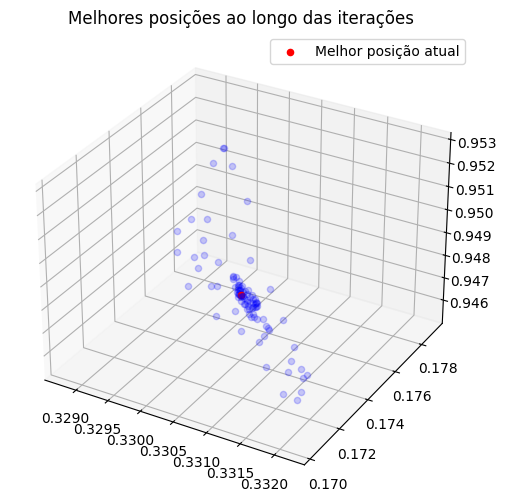

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 10
                              
Melhor custo: 63536946969290.4


In [172]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], best_positions[i, 2], c='blue', alpha=0.2)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], best_positions[-1, 2], c='red', label='Melhor posição atual')

ax.set_title('Melhores posições ao longo das iterações')
ax.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("                              ")
print("Melhor custo:", pbest_cost[0])